In [15]:
#Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sklearn.model_selection as skm 
from sklearn.model_selection import KFold,  GridSearchCV

import matplotlib.pyplot as plt



#load the dataset
data = pd.read_csv('C:/Users/Sowmy/OneDrive/Desktop/hw2/nhis_2022.csv')
#view first few roes of the data
print(data.head())
print(data.shape)

#drop survey columns
survey_cols = ['YEAR', 'SERIAL', 'STRATA', 'PSU', 'NHISHID', 'REGION',
               'PERNUM', 'NHISPID', 'HHX', 'SAMPWEIGHT', 'ASTATFLG', 'CSTATFLG']
data.drop(columns=survey_cols, inplace=True)
#Replace special missing codes
data.replace([996,997,998,999],np.nan,inplace=True)

# Define columns and their replacements
replace_7_9 = ['SEX', 'HINOTCOVE', 'CANCEREV', 'CHEARTDIEV', 'DIABETICEV', 'HEARTATTEV', 'STROKEV']
replace_97_98_99 = ['HOURSWRK', 'HRSLEEP']

# Replace 7 and 9 with NaN
data[replace_7_9] = data[replace_7_9].replace({7: np.nan, 9: np.nan})

# Replace 97, 98, 99 with NaN
data[replace_97_98_99] = data[replace_97_98_99].replace({97: np.nan, 98: np.nan, 99: np.nan})
#define the variables. 
variables = ['AGE', 'SEX', 'BMICALC', 'HRSLEEP', 'SODAPNO','FRIESPNO', 'DIABETICEV']
data  = data[variables]
#drop rows with nan value
data = data.dropna(subset=['DIABETICEV']).copy()

#Impute missing values with median age.
data['AGE'] = data['AGE'].fillna(data['AGE'].median())

#Impute missing values with mode.
data['SEX'] = data['SEX'].fillna(data['SEX'].mode()[0])

#Impute missing values with median
data['HRSLEEP'] = data['HRSLEEP'].fillna(data['HRSLEEP'].median())

#Drop rows with Nan values.
data = data.dropna()

data

   YEAR  SERIAL  STRATA  PSU         NHISHID  REGION  PERNUM  \
0  2022       1     143   16  0002022H000001       4       1   
1  2022       2     106   53  0002022H000003       3       1   
2  2022       2     106   53  0002022H000003       3       2   
3  2022       3     134   13  0002022H000006       2       1   
4  2022       4     106   53  0002022H000007       3       1   

            NHISPID      HHX  SAMPWEIGHT  ...  TOMSAUCEMNO  SODAPNO  FRIESPNO  \
0  0002022H00000110  H000001      8018.0  ...            2        0       110   
1  0002022H00000310  H000003     10117.0  ...            1        0         1   
2  0002022H00000320  H000003      7933.0  ...          996      996       996   
3  0002022H00000610  H000006      2681.0  ...            1        1         1   
4  0002022H00000710  H000007     10233.0  ...            3       30         5   

   SPORDRMNO  FRTDRINKMNO  COFETEAMNO  POTATONO  PIZZANO  HRSLEEP  CVDSHT  
0          3            0           0         3     

,AGE,SEX,BMICALC,HRSLEEP,SODAPNO,FRIESPNO,DIABETICEV
0,61.0,1.0,38.4,8.0,0.0,110.0,1.0
1,43.0,1.0,27.3,6.0,0.0,1.0,1.0
3,68.0,1.0,25.0,6.0,1.0,1.0,1.0
4,73.0,1.0,24.0,8.0,30.0,5.0,1.0
6,73.0,1.0,26.5,6.0,5.0,3.0,1.0
...,...,...,...,...,...,...,...
35106,84.0,2.0,20.7,9.0,0.0,1.0,1.0
35107,45.0,1.0,31.4,8.0,0.0,4.0,1.0
35108,47.0,2.0,36.3,8.0,0.0,1.0,1.0
35109,37.0,2.0,29.0,7.0,4.0,1.0,1.0


In [16]:
data['DIABETICEV'] = data['DIABETICEV'].map({1.0: 0, 2.0: 1}) # 1 = No diabetes, 2 = Has diabetes

# Define feature and target
X = data.drop('DIABETICEV', axis=1)
y = data['DIABETICEV']

#  Sample only 5000 rows for tuning
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=5000, random_state=42, stratify=y)

# Split into train and test (80/20)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

# Scale features
scaler = StandardScaler()
X_train_sample = scaler.fit_transform(X_train_sample)
X_test_sample = scaler.transform(X_test_sample)

#  Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10,100], 
}

svm = SVC(kernel='linear', class_weight='balanced', random_state=1)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train_sample, y_train_sample)

#  Now train on full dataset

# Split full data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the best model
final_svm = SVC(kernel='linear', C=grid_search.best_params_['C'], class_weight='balanced', random_state=1)
final_svm.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


SVC(C=1, class_weight='balanced', kernel='linear', random_state=1)

In [17]:
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}

svm_rbf = SVC(kernel='rbf', class_weight='balanced', random_state=1)
grid_rbf = GridSearchCV(svm_rbf, param_grid_rbf, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_rbf.fit(X_train_sample, y_train_sample)

#  Now train on full dataset for RBF kernel

# Split full data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the best RBF model
final_svm_rbf = SVC(kernel='rbf', 
                    C=grid_rbf.best_params_['C'], 
                    gamma=grid_rbf.best_params_['gamma'], 
                    class_weight='balanced', 
                    random_state=1)
final_svm_rbf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


SVC(C=100, class_weight='balanced', gamma=1, random_state=1)

In [20]:
param_grid_poly = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': [0.001, 0.01, 0.1]
}

svm_poly = SVC(kernel='poly', class_weight='balanced', random_state=1)
grid_poly = GridSearchCV(svm_poly, param_grid_poly, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_poly.fit(X_train_sample, y_train_sample)
#  Now train on full dataset for Polynomial kernel

# Split full data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the best Polynomial model
final_svm_poly = SVC(kernel='poly', 
                     C=grid_poly.best_params_['C'], 
                     degree=grid_poly.best_params_['degree'], 
                     gamma=grid_poly.best_params_['gamma'], 
                     class_weight='balanced', 
                     random_state=1)
final_svm_poly.fit(X_train, y_train)




Fitting 5 folds for each of 27 candidates, totalling 135 fits


SVC(C=0.1, class_weight='balanced', degree=2, gamma=0.001, kernel='poly',
    random_state=1)

Used 5000 rows samples for fast hypermeter tuning. Trained model on full dataset and scaled features before training.
Again for visulisation selected two key features AGE and BMICALC. Spliited into training and test data and scaled the features. Retrained tuned svm models only on these two features.
Plottted the decision boundaries as shown below.

In [19]:
# Select only two features
X_vis = data[['AGE', 'BMICALC']]
y_vis = data['DIABETICEV']
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X_vis, y_vis, test_size=0.2, random_state=42, stratify=y_vis)

#  Scale
scaler_vis = StandardScaler()
X_train_vis = scaler_vis.fit_transform(X_train_vis)
X_test_vis = scaler_vis.transform(X_test_vis)

#  Retrain tuned SVM models 

# Linear SVM
svm_linear_vis = SVC(
    kernel='linear',
    C=grid_search.best_params_['C'],
    class_weight='balanced',
    random_state=1
)
svm_linear_vis.fit(X_train_vis, y_train_vis)

# RBF SVM
svm_rbf_vis = SVC(
    kernel='rbf',
    C=grid_rbf.best_params_['C'],
    gamma=grid_rbf.best_params_['gamma'],
    class_weight='balanced',
    random_state=1
)
svm_rbf_vis.fit(X_train_vis, y_train_vis)

# Polynomial SVM
svm_poly_vis = SVC(
    kernel='poly',
    C=grid_poly.best_params_['C'],
    degree=grid_poly.best_params_['degree'],
    gamma=grid_poly.best_params_['gamma'],
    class_weight='balanced',
    random_state=1
)
svm_poly_vis.fit(X_train_vis, y_train_vis)
def plot_decision_boundary(model, X, y, title, sample_size=1000, grid_density=300):
    # Randomly sample smaller points
    if X.shape[0] > sample_size:
        idx = np.random.choice(X.shape[0], sample_size, replace=False)
        X = X[idx]
        y = y.iloc[idx] if hasattr(y, 'iloc') else y[idx]

    # Create smaller grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_density),
                         np.linspace(y_min, y_max, grid_density))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=15)
    plt.xlabel('AGE (scaled)')
    plt.ylabel('BMICALC (scaled)')
    plt.title(title)
    plt.show()


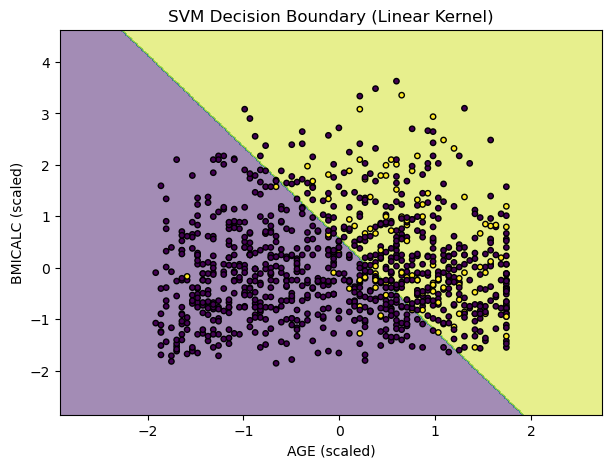

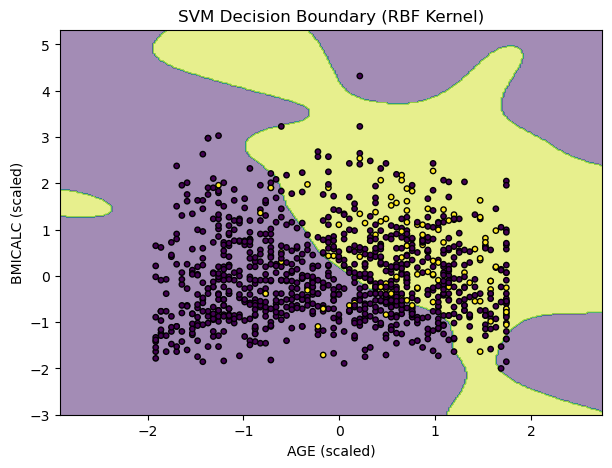

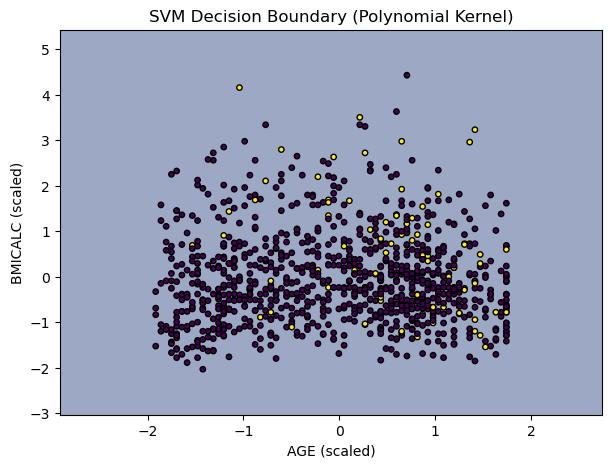

In [8]:
# Plot Linear SVM boundary
plot_decision_boundary(svm_linear_vis, X_train_vis, y_train_vis, 'SVM Decision Boundary (Linear Kernel)')

# Plot RBF SVM boundary
plot_decision_boundary(svm_rbf_vis, X_train_vis, y_train_vis, 'SVM Decision Boundary (RBF Kernel)')

# Plot Polynomial SVM boundary
plot_decision_boundary(svm_poly_vis, X_train_vis, y_train_vis, 'SVM Decision Boundary (Polynomial Kernel)')


Decision boundary plots were generated using AGE and BMI as predictors for diabetes status.

The Linear SVM produced a straight boundary, reflecting a simple separation between diabetic and non-diabetic individuals. However, the linear model struggled to fully capture the complexity of the relationship.

The RBF SVM formed a smooth, curved boundary to the data. We can see improved separation of the classes and better overall model performance. It  confirming that non-linear patterns exist between health behaviors and diabetes risk.

For the Polynomial SVM created an ineffective and oversimplified boundary, failing to meaningfully separate the two classes. 
Hence, the RBF kernel provided the most meaningful separation between diabetic and non-diabetic individuals based on AGE and BMI.

Used Support Vector Machine models with three types of kernels — linear, radial basis function , and polynomial , to predict diabetes based on people's age, BMI, sleep habits, and diet.

After tuning the models, the RBF SVM gave good accuracy, while the Linear SVM caught the most diabetic individuals. The Polynomial SVM did not perform well and was not a good fit for this problem.

Also made decision boundary plots using AGE and BMI. The Linear SVM made a straight line to separate diabetic and non-diabetic people, while the RBF SVM made a smooth, curved boundary that fit the data better. The Polynomial SVM could not separate the classes properly.

Overall, we found that diabetes can be predicted moderately well (around 70% accuracy) using basic information like age, BMI, sleep, and diet habits. People with higher BMI, older age, poor sleep, and unhealthy eating were more likely to have diabetes.


